在这里例子里，我们使用 `imdb` 数据集，对电影评论进行分类，分为“积极评论”和“消极评论”两类。

In [23]:
import numpy as np
from keras.datasets import imdb
from keras import models
from keras import layers
import matplotlib.pyplot as plt

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 4s 0us/step


其中 `num_words` 表示只保留最高频的 10000 个单词，生僻词会被丢弃，这能保证将数据转化为向量的时候能够保持一个固定的大小

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
max([max(sequence) for sequence in train_data])

9999

检查所有电影评论序列的单词 index 会发现，最大值为 9999，因为在上一步加载数据的时候限制了只保留最高频的 10000 个单词。

In [10]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# the indices are offset by 3 because 0, 1, 2 are reserved indices for
# "padding", "start of sequence" and "unknown"
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

由于神经网络只能接受固定大小的张量，所以字符串需要进行转换。最简单的方式是将其转换为 `one-hot` 向量。由于单词表为固定大小的 1000，所以转换之后的每个评论的结构为 `[0, 1, 0, 1, 1, ..., 1, 0]`，其中的 `1` 表示该评论里存在 `1` 所在下标对应的单词。值得注意的是，这样转换之后，序列的顺序这个信息便丢失了，即使存在重复的词，其值也是 `1`。

In [14]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [13]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [15]:
y_train[0]

1.0

数据准备就绪之后就能构建网络。对于这种输入是向量，输出是标量（0 和 1）的问题，一般使用全连接层。需要考虑的问题是

- 需要多少层
- 每层需要多少个隐藏单元

这些问题在深度学习领域大部分已经形成共识，后面会单独对这些“经验”进行总结。

In [36]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

其中 `relu` 激活函数将负数过滤，也就是 `relu(x) = max(x, 0)` 的效果。而 `sigmoid` 激活函数则将所有值映射到 `[0, 1]` 区间。通常输出值为概率的时候，都可以使用 `sigmoid` 激活函数。

In [37]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [38]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.5135 - accuracy: 0.8007 - val_loss: 0.3897 - val_accuracy: 0.8685
Epoch 2/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3098 - accuracy: 0.9024 - val_loss: 0.3257 - val_accuracy: 0.8725
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2302 - accuracy: 0.9259 - val_loss: 0.2803 - val_accuracy: 0.8910
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1821 - accuracy: 0.9405 - val_loss: 0.2787 - val_accuracy: 0.8889
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1488 - accuracy: 0.9519 - val_loss: 0.3125 - val_accuracy: 0.8770
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.1212 - accuracy: 0.9632 - val_loss: 0.2934 - val_accuracy: 0.8863
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.9711 - val_loss: 0.3028 - val_accuracy: 0.8863
Epoch 8/20
30/30 [=

训练过程的中间结果都保存在了 `history.history` 里

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

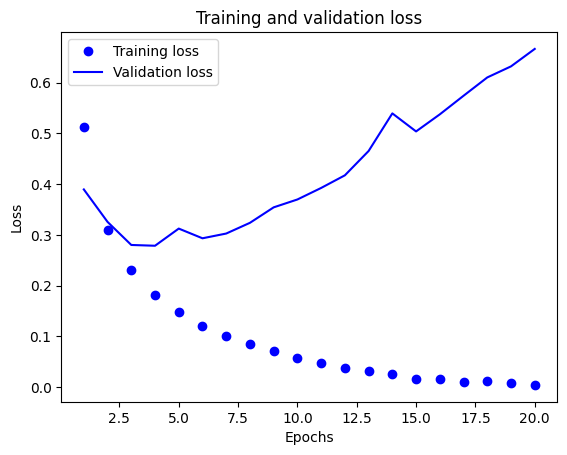

In [39]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # bo: blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # b: blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

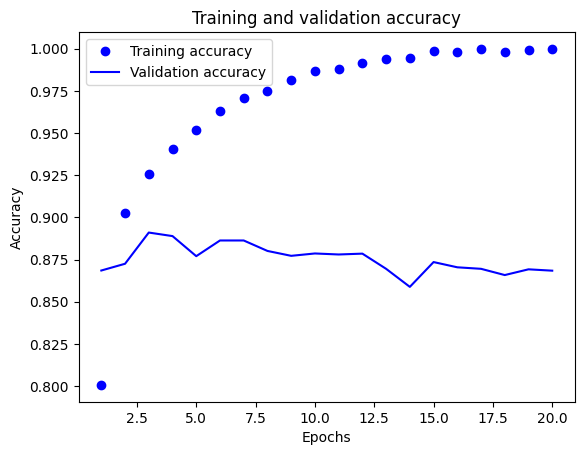

In [41]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training accuracy') # bo: blue dot
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy') # b: blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

从上面的训练结果来看，在第 4 个 epoch 之后，验证集的准确度在下降，误差在上升，证明从第 4 个 epoch 开始，网络已经开始过拟合了。如果将训练轮数改为 4，将能简单地解决这个问题。

调用 `model.predict` 来使用训练好的网络对测试数据进行预测。

In [27]:
model.predict(x_test)

782/782 [==============================] - 1s 791us/step


array([[0.00179653],
       [1.        ],
       [0.93999755],
       ...,
       [0.00189489],
       [0.00708264],
       [0.7380569 ]], dtype=float32)